In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

## Copying Relevant Mutation Code

In [3]:
############# Mutation Class #######################
class Mutation:
    def __init__(self, p, i, i_list, E, E_list, I, I_list):
        self.p = p# (chance of infection per interaction)
        self.i = i # 
        self.i_list = i_list # (tracks number of new mutations per day)
        self.E = E # (tracks each mutations Exposed individuals)
        self.E_list = E_list # (list of all Exposed values for each mutation)
        self.I = I # (tracks each mutations Infected individuals)
        self.I_list = I_list # (list of all Infected values for each mutation)
        self.i_updated = 0
        ## make functions that calculate these for me
    
    @classmethod
    def add_mutation(cls, p, i, i_list, E, E_list, I, I_list):
        return cls(p, i, i_list, E, E_list, I, I_list)

In [4]:
# make list of mutations to choose from
mutations = []
# List of mutations
p_values = [0.03, 0.01, 0.01, 0.07, 0.01, 0.01, 0.14]  # List of p values

for mutation in p_values:
    variant1 = Mutation.add_mutation(mutation, 0, [], 0, [], 0, [])
    mutations.append(variant1)

num_mutations = len(mutations)
q_list = np.zeros((num_mutations, num_mutations))

# Set the diagonal values to 0.99998 (0.99999 in the corners)
np.fill_diagonal(q_list, 0.99998)
q_list[0][0] = 0.99999
q_list[num_mutations-1][num_mutations-1] = 0.99999
# Set the off-diagonal values to 0.00001
np.fill_diagonal(q_list[:, 1:], 0.00001)
np.fill_diagonal(q_list[1:], 0.00001)

In [5]:
###### Multiple Random Mutations ############

# constant values
N = 1000000                            # Total population
K = 10                                 # Contact Rate
alpha = 0.1                            # Incubation rate
beta = 0.3                             # Infection rate
gamma = 0.1                            # Recovery rate
p = 0.03                               # Chance of infection per interaction                           
L = 20                                 # Lag from contracting to showing symptoms
x = 0.0002                             # Probability of infection per day
f = 0.01                               # Rate at which low risk of infection causes individuals to cease responding.
b = K     

times = np.arange(1, 2001)             # Number of "days" simulated

# Set aseir function to loop through times 
def aseir():
    # Initial values for ASEIR
    A = 0  
    S = N  
    E = 0  
    I = 0  
    R = 0  
    I_lag = np.zeros(len(times) + L + 1)  # list of i values at each time t
    results = []  # list to store data from aseir model
    days_without_mutation = 0  # tracks the number of days without mutation
    
    for t in times:
        
        i = 0
        for m in mutations:
            m.i = (1 - (A/N)*(m.p*K*I_lag[t])/(x*N + m.p*K*I_lag[t])) * m.p * K * S * m.I / N
            m.i_list.append(m.i)
            i += m.i
            
        for m in mutations:
            m.i_updated = m.i
            for n in mutations:
                j = mutations.index(m)
                k = mutations.index(n)
        
                # Update m.i_updated using the q_list
                m.i_updated = m.i_updated - (q_list[j, k] * m.i) + (q_list[k, j] * n.i) 
                
        for m in mutations:
            m.i = m.i_updated
            
            
        S = S - i  # change in Susceptible individuals
            
        E = 0
        if (t == 1):
            mutations[0].E = 1
            mutations[0].E_list.append(mutations[0].E)
            E = 1
        else:
            for m in mutations:
                m.E = m.E + m.i - alpha * m.E
                m.E_list.append(m.E)
                # add sum for total of E values in mutations
                E += m.E
        
        I = 0  # change in Infected individuals
        for m in mutations:
            m.I = m.I + alpha * m.E - gamma * m.I
            m.I_list.append(m.I)
            # add sum for total of I values in mutations
            I += m.I
        
        R = R + gamma * I  # change in Recovered individuals
        A = A + b * (N - A) * I_lag[t] / N - A * f * (1 - b * I_lag[t] / N)
        I_lag[t + L] = I  # update lagged values
        
        results.append([t, A, S, E, I, R, i, p])

    return results
    


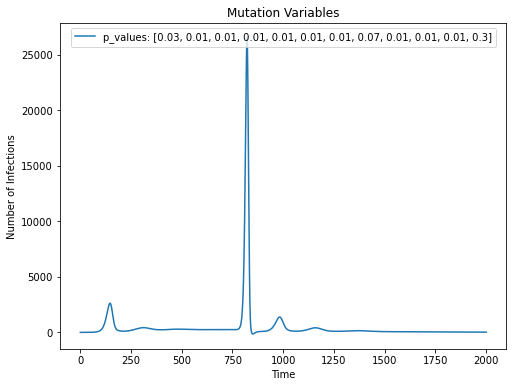

In [33]:
# make list of mutations to choose from
mutations = []
#List of mutations

p_values_list = [
    [0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.07, 0.01, 0.01, 0.01, 0.30]

]
#p_values_list = [
#    [0.03, 0.03, 0.03, 0.07, 0.03, 0.03, 0.21],
#    [0.03, 0.03, 0.03, 0.03, 0.03, 0.07, 0.03, 0.03, 0.03, 0.03, 0.21]
#]
# Initialize a list to store all the dataframes
all_dfs = []

# Loop over each set of p_values
for p_values in p_values_list:
    # Clear mutations list
    mutations.clear()
    
    # Create mutations
    for mutation in p_values:
        variant = Mutation.add_mutation(mutation, 0, [], 0, [], 0, [])
        mutations.append(variant)
    
    num_mutations = len(mutations)
    q_list = np.zeros((num_mutations, num_mutations))

    # Set the diagonal values to 0.99998 (0.99999 in the corners)
    np.fill_diagonal(q_list, 0.99998)
    q_list[0][0] = 0.99999
    q_list[num_mutations-1][num_mutations-1] = 0.99999
    # Set the off-diagonal values to 0.00001
    np.fill_diagonal(q_list[:, 1:], 0.00001)
    np.fill_diagonal(q_list[1:], 0.00001)

    # Run simulation
    data = aseir()
    columns = ["t", "A", "S", "E", "I", "R", "i", "p"]
    df = pd.DataFrame(data, columns=columns)
    
    # Store the dataframe
    all_dfs.append(df)

# Plot all dataframes on the same graph
plt.figure(figsize=(8, 6))
for i, df in enumerate(all_dfs):
    plt.plot(df['t'], df['i'], label=f'p_values: {p_values_list[i]}')
plt.xlabel('Time')
plt.ylabel('Number of Infections')
plt.title('Mutation Variables')
plt.legend(loc='upper center')
plt.show()


## Importing Preprocessed Data

In [7]:
processed_data = pd.read_csv("../Dataframes/processed_data.csv")

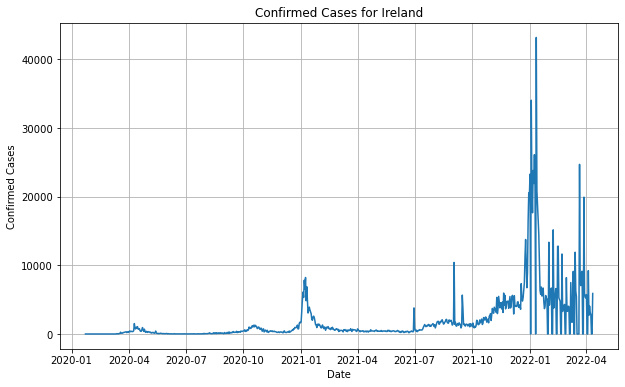

In [8]:
dates = pd.to_datetime(processed_data.iloc[:, 0])

# Step 3: Extract the values for the desired country
country_column = 'Ireland'  # Replace 'Country_Name' with the actual column name
country_values = processed_data[country_column]

# Step 4: Plot the values against the dates
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(dates, country_values)
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Cases for {}'.format(country_column))
plt.grid(True)
plt.show()

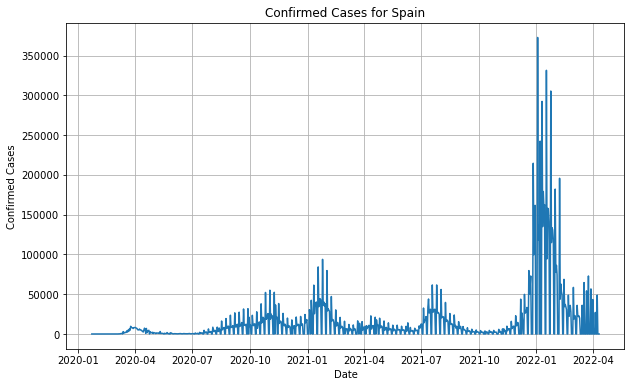

In [28]:
dates = pd.to_datetime(processed_data.iloc[:, 0])

# Step 3: Extract the values for the desired country
country_column = 'Spain'  # Replace 'Country_Name' with the actual column name
country_values = processed_data[country_column]

# Step 4: Plot the values against the dates
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(dates, country_values)
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Cases for {}'.format(country_column))
plt.grid(True)
plt.show()

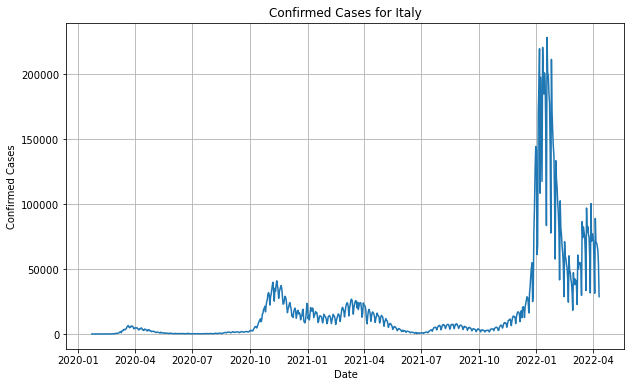

In [29]:
dates = pd.to_datetime(processed_data.iloc[:, 0])

# Step 3: Extract the values for the desired country
country_column = 'Italy'  # Replace 'Country_Name' with the actual column name
country_values = processed_data[country_column]

# Step 4: Plot the values against the dates
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(dates, country_values)
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed Cases for {}'.format(country_column))
plt.grid(True)
plt.show()

In [35]:
datelist = pd.date_range(dates[0], periods=len(times)).tolist()
df["Dates"] = datelist

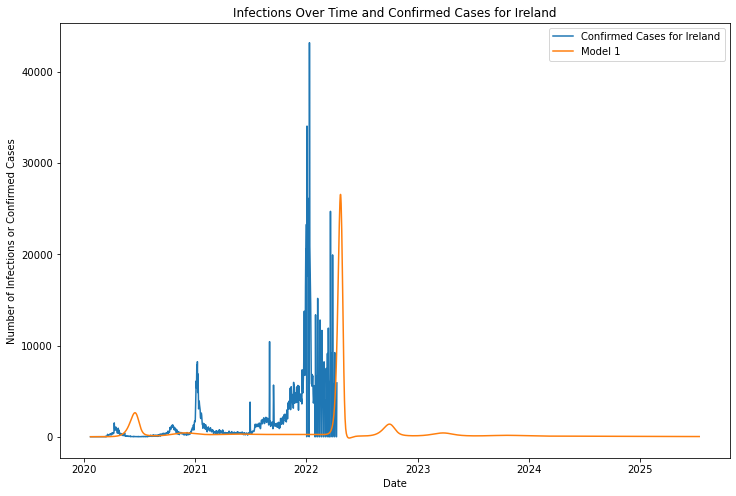

In [36]:
# Plot the graphs
plt.figure(figsize=(12, 8))  # Adjust figure size as needed


# Extract dates
dates = pd.to_datetime(processed_data.iloc[:, 0])

# Extract the values for the desired country
country_column = 'Ireland'
country_values = processed_data[country_column]
# Plot the second graph
plt.plot(dates, country_values, label='Confirmed Cases for {}'.format(country_column))

# Plot the first graph
plt.plot(df['Dates'], df['i'], label='Model 1')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Infections or Confirmed Cases')
plt.title('Infections Over Time and Confirmed Cases for {}'.format(country_column))

# Add legend
plt.legend()

# Show the plot
plt.grid(False)
plt.show()